In [8]:
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget

## functions

In [2]:
def find_movement(raw, time, mscl, window, thrs, thrs2, positive):
    
    # 0. Select data
    # ms to select time window to find movement start (ms)
    try:
        start = time[0]
        end=time[1]
    except:
        start = time[0]
        end = raw.to_data_frame().time.max()

    #filters
    # low catoff
    l = 5
    # high catoff
    h = 2200
    
    dat = raw.filter(l_freq=l, h_freq=h, verbose=False).to_data_frame()[(raw.filter(l_freq=l, h_freq=h,verbose=False).to_data_frame().time>=start)&(raw.filter(l_freq=l, h_freq=h,verbose=False).to_data_frame().time<=end)]
    
    # lists to save information  - do not change
    time = []
    cond_result = []
    result = []

    # 1. Sliding window to check condition 
    for m in range(dat.time.min(), dat.time.max()):

        # selects data in the time window
        wnd = np.abs(dat[(dat.time>=m)&(dat.time<=m+window)][mscl])

        # check whether Share of picks higher than "thrs" is more than "pisitive" in the window
        cond = np.where(wnd>=thrs, 1, 0).sum()/len(wnd)>=positive

        # save condition check result (True, False) and first timestamp of the window
        cond_result.append(cond)
        time.append(m)

        # save first timestamps of windows where cond was True
        if cond == True:
            result.append(m)


    # 2. Find "start" and "end" of movement
    result3 = pd.DataFrame({'times':time, 'result':cond_result})
    result3['previous'] = result3.result.shift(1)
    result3['change'] = result3.result - result3.previous

    trig = result3[result3.change.isin([1,-1])].reset_index(drop=True)
    trig['movement'] = np.where(trig.change==1, 'start', 'end')



    # 3. select times in the suitable windows preciselly 
    res = []
    for tr in trig.times:
        wnd = np.abs(dat[(dat.time>=tr)&(dat.time<=tr+window)])

        if trig[trig.times==tr].movement.values[0] == 'start':
            # select time when uV achived thrs first
            first = wnd[wnd[mscl]>=thrs2].time.min()
            res.append(first)
        else: 
            last = wnd[wnd[mscl]>=thrs2].time.max()
            res.append(last)
            
    return res, dat


def plot_signal(data, movement_time):
    
    fig, (ax0) = plt.subplots(nrows=1)

    for r in movement_time:
        ax0.axvline(x=r, color='r')

    ax0.plot(data.time, data[mscl], label='signal')
    ax0.legend()
    
    
def plot_emg_events(raw, movement_time):
    events = pd.DataFrame({'time':np.array(movement_time)*5, 'event_value':1, 'event_name':list(range(1,len(np.array(movement_time))+1))})
    raw.plot(n_channels=1, event_color='red', 
             events=np.array(events), 
             scalings=1e-3, 
             highpass=10, lowpass=2200)
    
def create_events(movement_time):
    events = pd.DataFrame({'time':np.array(movement_time), 'event_value':1, 'event_name':list(range(1,len(np.array(movement_time))+1))})
    return events

    

from ipywidgets import widgets  
from ipywidgets import interact, interactive, fixed, interact_manual 

def adjust_movements(ev):
    
    #raw file to dataframe
    data = raw.filter(l_freq=5, h_freq=2200, verbose=False).to_data_frame()
    
    # create widget to list events with button 'next event'
    button=widgets.Button(
        value=False,
        description='Next event',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Description',
        icon='Saved' # (FontAwesome names without the `fa-` prefix)
                        )

    
    l = [] # for loop - indexes list of redo events 
    new_ts = [] # list to save new times stamp

    def plus(sender):
        l.append(1)
        index = np.array(l).sum()
        try:
            
            # create windget to Change event position
            w = widgets.FloatText(
            value=ev[index-1],
            min=ev[index-1]-800,
            max=ev[index-1]+3000,
            step=5,
            description='New Value uV:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            )
            
            # function for visualisation of new timestamp based on windget to Change event position
            def f(x):
                fig, (ax0) = plt.subplots(nrows=1)
                ax0.axvline(x=x, color='r')
                ax0.plot(data[(data.time>=ev[index-1]-800)&(data.time<=ev[index-1]+3000)].time, 
                         data[(data.time>=ev[index-1]-800)&(data.time<=ev[index-1]+3000)][mscl], label='signal') 

            
            # create Button to save new position
            b=widgets.Button(
                value=False,
                description='Save timestamp',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
                tooltip='Description',
                icon='Saved' # (FontAwesome names without the `fa-` prefix)
                )
            
            
            saved_ts=[] # new timestamp list
            
            # function of button 'save timestemp' - it saves new value to the list
            def but(sender):
                saved_ts.append(w.value)

            b.on_click(but)
            display(b,interactive(f, x=w))
            new_ts.append(saved_ts)
            
        except Exception as e:
            print("You finished")


    button.on_click(plus)
   

    
    return display(button),new_ts


from oauth2client.service_account import ServiceAccountCredentials
import gspread_dataframe as gsp
import gspread

# 1. SET UP GOOGLE SHEET API
# ----------- CHANGE CREADENTIALS LOCATION ------------------------
current_dir = '/Users/ksenia.kozlova/Downloads' 
GSPREAD_KEYS_PATH = current_dir + '/esoteric-pad-326113-4ab241befdd8.json' # this is the directory where your file with key located
 

# Some functions for authorizing (no need to change something here)
def authorize_at_gspread(gspread_key_path=GSPREAD_KEYS_PATH):
    """
    Return authorized gspread object
    :param gspread_key_path: path to credentials key
    :return: gc object
    """
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(GSPREAD_KEYS_PATH, scope)
    gc = gspread.authorize(credentials)
    return gc
# authorization
authorize_at_gspread()


# 2. Function for particular sheet connection
def get_workbook(workbook_url, gspread_key_path=GSPREAD_KEYS_PATH):
    """ Returns GSPREAD object with opened workbook.
    Just open worksheet by referring to .worksheet(name) or use gspread_dataframe to load dataframe.
    """
    gc = authorize_at_gspread(gspread_key_path=gspread_key_path)
    return gc.open_by_url(workbook_url)


# Damir - to write to a sheet fucntion
def tospreadsheet (df, workbook_link, header = 'Title', key = 'new'):
    """Import dataframe to google spreadsheet by link
    Args: 
        df: imported dataframe
        workbook: link to dataframe
        header: header of worksheet 
        key: default 'new'
        if you want to use existing worksheet pass 'to existing sheet'

    """
    if key == 'new':
        workbook = get_workbook(workbook_link)
        wks = workbook.add_worksheet(header, len(df.index),len(df.columns))
        gsp.set_with_dataframe(wks, df, row = 1, col =1, include_column_header=True)

    elif key == 'existing':
        workbook = get_workbook(workbook)
        wks = workbook.worksheet(header)
        gsp.set_with_dataframe(wks, df, row = 1, col =1, include_column_header=True)
        

def gsheet(header,new_t):
    
    new = pd.DataFrame({'events_to_correct':redo})
    new2=pd.concat([new, pd.DataFrame(new_t[1])], axis=1).set_index('events_to_correct')

    result = events[['time','event_name']].set_index('event_name')

    final = pd.concat([result,new2],axis=1)
    final['muscle'] = mscl
    final['file'] = path[-20:path.find('.vhdr')][path[-20:path.find('.vhdr')].find('/')+1:]
    final['final_corrected_movement_time'] = np.where(final[0].isna==False,final[0],final.time )
    
    link = 'https://docs.google.com/spreadsheets/d/1g0wJeyONCuivtppNc352MBkBIyOgY7FxkQq5XgaBjsg/edit?usp=sharing'

    tospreadsheet(final, link, header)

    return final


__Notebook  widgets set up commands and libraries (allow to plot interractive charts - essencial for "Plot emg"):__

In [7]:
!ipython notebook --pylab=inline
#!conda install -c conda-forge/label/cf202003 nodejs
#!conda install -y nodejs
# pip install ipympl
# pip install --upgrade jupyterlab
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter labextension install jupyter-matplotlib
# jupyter nbextension enable --py widgetsnbextension

[TerminalIPythonApp] WARNING | Subcommand `ipython notebook` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter notebook` in the future
[E 21:16:46.998 NotebookApp] Support for specifying --pylab on the command line has been removed.
[E 21:16:46.999 NotebookApp] Please use `%pylab inline` or `%matplotlib inline` in the notebook itself.


## Uppload data

In [3]:
# 1. file path
path = '/Users/ksenia.kozlova/Downloads/New trial/PoAn_12/PoAN_APB_3.vhdr'


raw = mne.io.read_raw_brainvision(path,verbose=False)

<ipython-input-3-9c645a8a128b>:5: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(path,verbose=False)


__Information about the record__

In [4]:
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: rAPB, rADM, rECU, lAPB, lADM, lECU
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 10.0 Hz
 lowpass: 2500.0 Hz
 meas_date: 2021-03-05 19:01:25 UTC
 nchan: 6
 projs: []
 sfreq: 5000.0 Hz
>


In [5]:
# apply notch if needed
notch = raw.load_data().copy().notch_filter(freqs=(50),verbose=False) #filter

## Plot EMG

__INSTRUCTION__

To move recording by time:
- just click on the plot to activate
- push arrows ">" and "<" on the keyboard

To set up uV:
- just click on the plot to activate
- press "+" and "-" in the keyboard

To expand plot window:
- just click on the plot to activate
- pull triangular icon in the down right corner: 


To save plot picture:
- press the icon on the left pannel: 
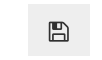


To zoom part of signal:
- press the following icon on the left pannel, then select part of interest
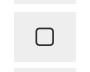
- click the arrow to move chart
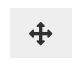
- press the icon to back normal view
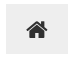


In [9]:
#to plot
try:
    notch.plot(highpass=10, lowpass=2200)
except: 
    raw.plot()

Setting up band-pass filter from 10 - 2.2e+03 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 2200.00 Hz: -6.02, -6.02 dB



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Find movement ALGO

__1. Setup AlGO parameters__

1.1. Select trail part of data with 3-5 movements 

In [10]:
# adjast
muscle = 'rAPB'
start_trial = 8000
end_trial = 23000


# no changes
dat = raw.filter(l_freq=5, h_freq=2200, verbose=False).to_data_frame()[(raw.filter(l_freq=5, h_freq=2200,verbose=False).to_data_frame().time>=start_trial)&(raw.filter(l_freq=5, h_freq=2200,verbose=False).to_data_frame().time<=end_trial)]


Plot Trial signal

In [11]:
# no change
fig, (ax0) = plt.subplots(nrows=1)
ax0.plot(dat.time, dat[str(muscle)])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

2. Adjast. parameters (active msck, thrs, thrs2)

In [12]:
# ADJUST

# 1.muscle
mscl = 'rAPB' #rapb

# 2. Thresholds, (absolut value) uV activity threshold which concidered as a movement 
# thrs - general, thrs2 is more accurate in subwindow 
thrs = 27 
thrs2 = 10


# 3. time window to analyse (ms)
# 650 is optimal 
window = 650 

# 4. percentage of picks which should be higher than thrs in the window 
# 0.05 is optimal
positive = 0.05 


3. Try algo settings on trial data at first.

In [13]:
# no changes
# start and end in ms
trial_time = [start_trial, end_trial]
# Run algo on trial data
trial_movement_time, trial_data = find_movement(raw, trial_time, 'rAPB', window, thrs, thrs2, positive)


In [14]:
# plot trial
plot_signal(trial_data, trial_movement_time)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

__If the Movement start is not acurate enough, Adjast thrs,thrs2 and try again #2__

4. Apply to the whole recording (here time = [0] which means "start from 0 second"

In [15]:
movement_time, data = find_movement(raw, [0], 'rAPB', window, thrs, thrs2, positive)

In [16]:
# plot Algo Markup way1
plot_signal(data, movement_time)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Manual adjastment of Algo Movement Markup

In [17]:
# plot Algo Markup way2
plot_emg_events(raw, movement_time)

Setting up band-pass filter from 10 - 2.2e+03 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 2200.00 Hz: -6.02, -6.02 dB



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

__1. save number of events to redo__

In [18]:
# change
redo = [13,21,27,29,37]

In [19]:
# no change
events = create_events(movement_time)

In [20]:
events[events.event_name.isin(redo)].reset_index().time

0     38137.0
1     61852.0
2     80283.0
3     86316.0
4    109520.0
Name: time, dtype: float64

__2. Manually adjast movement markup__

In [21]:
new_timings = adjust_movements(events[events.event_name.isin(redo)].reset_index().time)

Button(description='Next event', icon='Saved', style=ButtonStyle(), tooltip='Description')

Button(description='Save timestamp', icon='Saved', style=ButtonStyle(), tooltip='Description')

interactive(children=(FloatText(value=38137.0, description='New Value uV:', step=5.0), Output()), _dom_classes…

Button(description='Save timestamp', icon='Saved', style=ButtonStyle(), tooltip='Description')

interactive(children=(FloatText(value=61852.0, description='New Value uV:', step=5.0), Output()), _dom_classes…

Button(description='Save timestamp', icon='Saved', style=ButtonStyle(), tooltip='Description')

interactive(children=(FloatText(value=80283.0, description='New Value uV:', step=5.0), Output()), _dom_classes…

Button(description='Save timestamp', icon='Saved', style=ButtonStyle(), tooltip='Description')

interactive(children=(FloatText(value=86316.0, description='New Value uV:', step=5.0), Output()), _dom_classes…

__3. Save Movement times to Google sheet together with adjasted__

In [22]:
# change
sheet_name = 'trial_demo'

corrected_time = gsheet(sheet_name, new_timings)

__See movement times in the file:__

https://docs.google.com/spreadsheets/d/1g0wJeyONCuivtppNc352MBkBIyOgY7FxkQq5XgaBjsg/edit?usp=sharing

In [21]:
corrected_time

,time,0,1,muscle,file,final_corrected_movement_time
1,2671.0,NaN,NaN,rAPB,PoAN_APB_3,2671.0
2,4437.0,NaN,NaN,rAPB,PoAN_APB_3,4437.0
3,8422.0,NaN,NaN,rAPB,PoAN_APB_3,8422.0
4,10515.0,NaN,NaN,rAPB,PoAN_APB_3,10515.0
5,14604.0,NaN,NaN,rAPB,PoAN_APB_3,14604.0
6,16615.0,NaN,NaN,rAPB,PoAN_APB_3,16615.0
7,20537.0,NaN,NaN,rAPB,PoAN_APB_3,20537.0
8,22540.0,NaN,NaN,rAPB,PoAN_APB_3,22540.0
9,26290.0,NaN,NaN,rAPB,PoAN_APB_3,26290.0
10,28453.0,NaN,NaN,rAPB,PoAN_APB_3,28453.0


## Plot signal with final movement start Markups

In [23]:
plot_emg_events(raw, corrected_time.final_corrected_movement_time)

Setting up band-pass filter from 10 - 2.2e+03 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 2200.00 Hz: -6.02, -6.02 dB



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Movement time found - the end